<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/minimal_VQVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## VQ-VAE: learning a discrete language for continuous data

(Fayyaz Minhas)

Many representation learning models compress data into a continuous latent vector. That works well for reconstruction, but it does not naturally produce a **finite vocabulary** of reusable latent states. Yet in many domains we believe such vocabularies exist: phonemes in speech, motifs in biology, tokens in language, phenotypes in imaging. We want a model that both reconstructs data and discovers a **discrete set of latent prototypes** that can be reused across samples.

Vector-Quantised Variational Autoencoders (VQ-VAEs) were designed precisely for this. They take the familiar autoencoder pipeline and insert a learned discrete bottleneck. The encoder produces a continuous latent suggestion, but the model is forced to express that suggestion using one element from a finite learned dictionary. The result is a representation that behaves like clustering, compression, and symbolic abstraction all at once.

Once the motivation is clear, we can analyse the model using the Representation–Evaluation–Optimisation lens.

---

## The representation VQ-VAE enforces

Given an input $x$, the encoder produces a continuous latent vector  
$$
z_e = f_\theta(x).
$$

Instead of passing this directly to the decoder, we maintain a set of learnable codebook vectors  
$$
\{e_1,\dots,e_K\}.
$$

The model then performs nearest-neighbour quantisation  
$$
k^* = \arg\min_k \|z_e - e_k\|^2,
\qquad
z_q = e_{k^*}.
$$

Finally the decoder reconstructs  
$$
\hat{x} = g_\phi(z_q).
$$

So the full representation pipeline is  
$$
x \rightarrow z_e \rightarrow z_q \rightarrow \hat{x}.
$$

Conceptually, the encoder proposes a latent description, but the system replies:  
“You are only allowed to use one of these official latent symbols.”

Over training, three things happen simultaneously:

- encoder outputs cluster in latent space  
- codebook vectors move toward those clusters  
- decoder learns how to interpret each code  

The representation therefore becomes **discrete but learned**, not fixed.

---

## Why loss terms are needed: the tension in the system

Once we insert quantisation, the system becomes unstable unless we add the right evaluation terms. Each loss component exists to resolve a specific tension between encoder, codebook, and decoder.

The total objective is  
$$
\mathcal{L}
=
\mathcal{L}_{\text{recon}}
+
\mathcal{L}_{\text{codebook}}
+
\beta\,\mathcal{L}_{\text{commit}}.
$$

To understand this properly, we need to ask what could go wrong if we only optimised reconstruction.

---

## Reconstruction loss: preserving information

The first requirement is obvious. After compressing through a discrete code, we still want to reconstruct the input  
$$
\hat{x} \approx x.
$$

So we penalise  
$$
\mathcal{L}_{\text{recon}} = \|x - \hat{x}\|^2.
$$

This ensures that the discrete representation retains enough information to describe the input. Without this term, the model could assign arbitrary codes to inputs without caring whether anything meaningful is preserved.

However, reconstruction alone does not guarantee that the discrete bottleneck will actually be used properly. The encoder might drift arbitrarily, or the codebook might never move.

So we need additional structure.

---

## Codebook loss: prototypes must move toward the data

Suppose an encoder output $z_e$ repeatedly selects code $k$. If the codebook vector $e_k$ does not move toward those encoder outputs, the codebook remains random and useless. We therefore need a mechanism that makes codebook vectors track the data assigned to them.

We introduce the codebook loss  
$$
\mathcal{L}_{\text{codebook}}
=
\|z_q - \text{sg}[z_e]\|^2.
$$

The stop-gradient operator $\text{sg}[\cdot]$ means that only the codebook vectors are updated by this term, not the encoder. Intuitively, this makes each codebook vector behave like a cluster centre that moves toward the encoder outputs that choose it.

Without this term, the encoder might learn meaningful structure but the codebook would remain fixed, making quantisation arbitrary.

This loss enforces the principle that the vocabulary must adapt to the data.

---

## Commitment loss: the encoder must commit to a code

Now consider the opposite problem. If the encoder can wander freely in latent space while only occasionally snapping to a codebook vector, assignments become unstable. Small changes in the encoder output might cause large changes in the chosen code. Training becomes noisy and inconsistent.

To stabilise this, we penalise the distance between the encoder output and its chosen code  
$$
\mathcal{L}_{\text{commit}}
=
\|z_e - \text{sg}[z_q]\|^2.
$$

This term updates only the encoder. It forces the encoder to stay close to the discrete code it has selected.

Intuitively, the codebook moves toward the encoder (codebook loss) while the encoder moves toward the codebook (commitment loss). They meet in the middle. This mutual attraction stabilises the discrete representation.

The coefficient $\beta$ controls how strongly we enforce commitment. If it is too small, the encoder wanders and assignments fluctuate. If too large, the encoder may collapse onto a few codes.

This loss enforces the principle that once you choose a symbol, stay close to it.

---

## Why both losses are required

The codebook loss alone would cause codebook vectors to chase encoder outputs, but the encoder could move freely, leading to unstable assignments. The commitment loss alone would force encoder outputs toward codebook vectors, but the codebook might never move to reflect the data.

Together, they create a stable equilibrium where

- codebook vectors represent cluster centres  
- encoder outputs form tight clusters around them  

This is essentially k-means clustering embedded inside an autoencoder, but trained with gradient descent.

---

## Perplexity: are we actually using the vocabulary?

A useful diagnostic is the distribution of code usage. Let $p_k$ be the fraction of inputs assigned to code $k$. We compute the entropy  
$$
H = -\sum_k p_k \log p_k,
$$
and define the perplexity  
$$
\exp(H).
$$

If perplexity is near 1, only one code is used. This indicates collapse.  
If perplexity is near $K$, all codes are used evenly.  
In practice, we expect something in between.

This tells us whether the discrete representation is meaningful or degenerate.

---

## Optimisation: making quantisation trainable

The nearest-neighbour selection step is not differentiable. To train the model with gradient descent, we use a straight-through estimator. In the forward pass, we use the quantised vector  
$$
z_q = e_{k^*}.
$$

In the backward pass, we treat it as if it were the encoder output  
$$
z_q = z_e + (z_q - z_e)_{\text{detach}}.
$$

This allows gradients to flow into the encoder even though the assignment itself is discrete.

Over training iterations, this produces a dynamic in which

- encoder outputs cluster  
- codebook vectors move toward clusters  
- decoder learns to interpret each code  

The system gradually discovers a discrete latent vocabulary.

---

## The toy experiment

To make this concrete, we run a simple experiment on 2D clustered data. Each point lies in one of several Gaussian clusters. We train a VQ-VAE with a small codebook and visualise

- original points and reconstructions in input space  
- encoder outputs and quantised outputs in latent space  
- codebook vectors  
- training losses and perplexity  

We expect to see encoder outputs forming clusters, with codebook vectors moving toward cluster centres. Reconstructions should overlap with original points, demonstrating that the discrete representation preserves structure.

This toy example reveals the essential behaviour of VQ-VAE in a setting where everything can be visualised directly. The same principles scale to images, audio, and biological data.

## Handling dead codes

A known failure mode of VQ-VAE models is the emergence of *dead* or unused codebook vectors. Because codebook entries are typically updated only when selected by the encoder, some vectors may never receive gradient updates and remain permanently inactive. This leads to poor utilisation of the discrete vocabulary and reduced model capacity.

Several approaches in the literature address this issue. One strategy is to make the quantisation step probabilistic rather than strictly nearest-neighbour, allowing multiple codebook entries to receive gradient signal during training and preventing early collapse. Another approach is to improve codebook initialisation or update rules so that unused codes are periodically reintroduced into regions of the latent space occupied by data. Recent work also explores freezing large codebooks and instead learning a projection from encoder outputs into that codebook, ensuring that all entries participate in optimisation even if they are not selected at every step. Hierarchical or multi-level quantisation has likewise been shown to distribute usage more evenly across codebook entries.

In practice, common mitigation strategies include exponential moving-average updates of codebook vectors, occasional reinitialisation of inactive codes, stochastic assignment during training, and monitoring codebook utilisation through metrics such as perplexity.

Relevant papers:

- Oord, A. v. d., Vinyals, O., & Kavukcuoglu, K. (2017). *Neural discrete representation learning*. Advances in Neural Information Processing Systems.  
- Razavi, A., van den Oord, A., & Vinyals, O. (2019). *Generating diverse high-fidelity images with VQ-VAE-2*. NeurIPS.  
- Williams, W. et al. (2020). *Hierarchical quantized autoencoders*. NeurIPS.  
- Yu, J. et al. (2024). *Scaling the codebook size of VQ-GAN to 100,000 with a utilization rate of 99%*. NeurIPS.





Epoch    1 | total=20.3667 recon=18.2276 vq=2.1391 perplexity=4.03
Epoch   50 | total=62.4050 recon=0.3280 vq=62.0770 perplexity=3.98
Epoch  100 | total=3.8720 recon=0.4459 vq=3.4261 perplexity=3.98
Epoch  150 | total=6.2883 recon=0.7770 vq=5.5113 perplexity=3.98
Epoch  200 | total=7.5207 recon=1.1389 vq=6.3819 perplexity=3.97
Epoch  250 | total=6.8058 recon=0.7734 vq=6.0325 perplexity=3.97
Epoch  300 | total=6.3758 recon=0.7856 vq=5.5902 perplexity=3.98
Epoch  350 | total=6.2538 recon=0.6354 vq=5.6184 perplexity=3.99
Epoch  400 | total=5.9949 recon=0.4602 vq=5.5347 perplexity=3.99


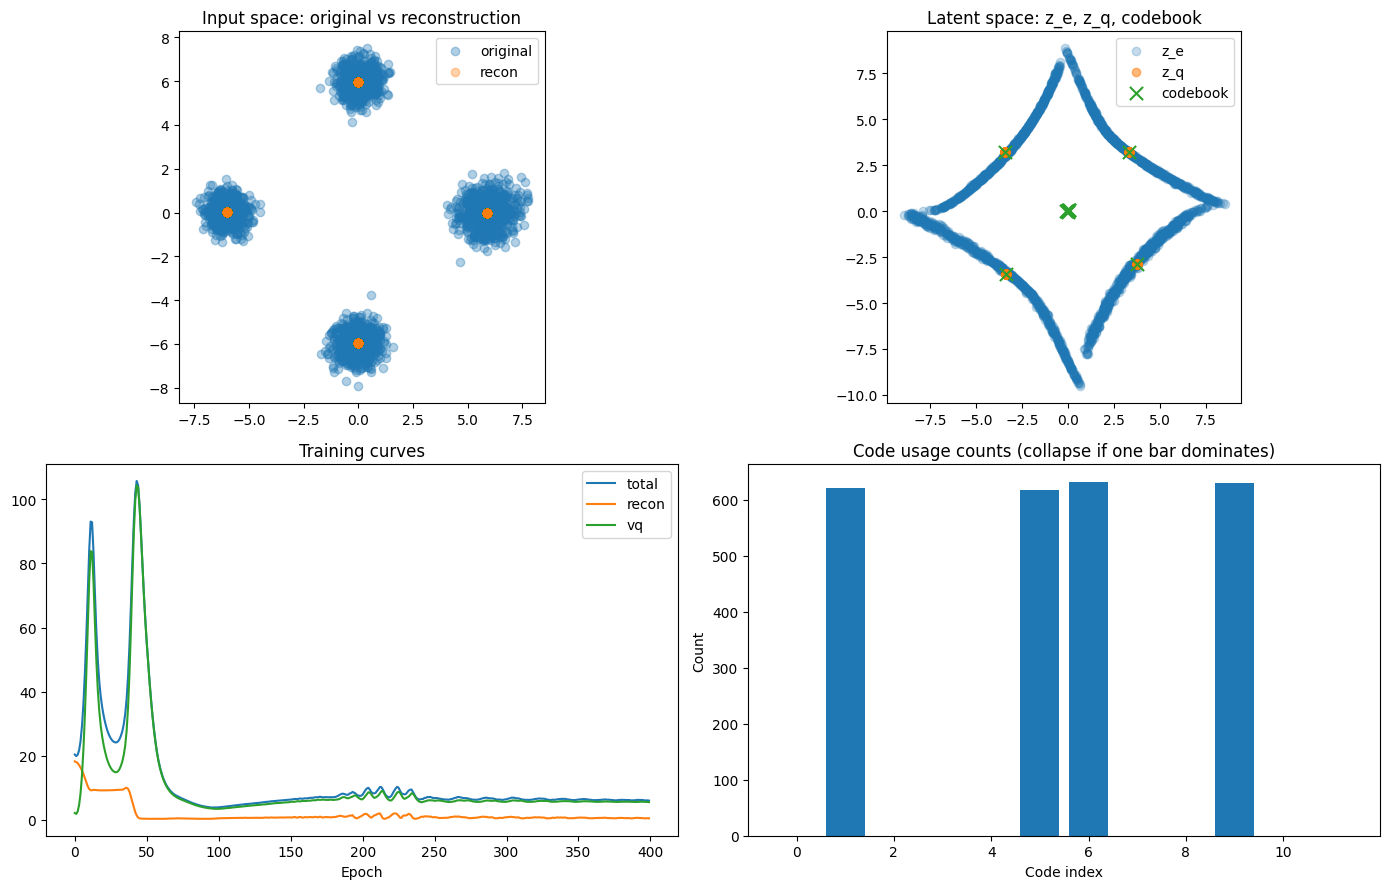

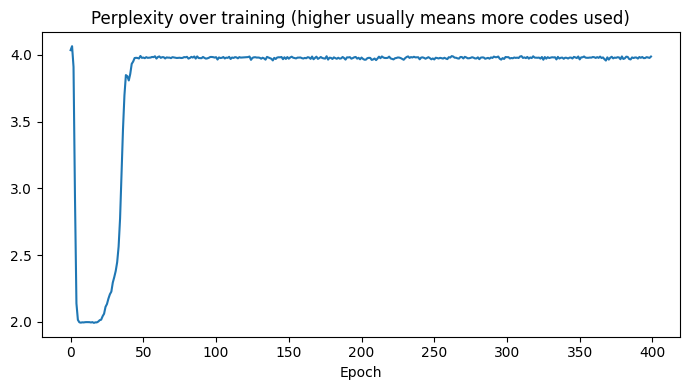

In [1]:
"""
VQ-VAE tutorial on a 2D toy dataset (Gaussian mixture).

What you will see
-----------------
1) A synthetic dataset: 2D points sampled from a Gaussian mixture.
2) A small VQ-VAE trained to reconstruct the 2D points.
3) Plots showing:
   - Original points and reconstructions in input space
   - Encoder latents z_e and quantised latents z_q in latent space
   - Codebook vectors (embedding table) in latent space
   - Training curves for reconstruction and VQ loss
   - Code usage histogram and perplexity

Key VQ-VAE ideas
----------------
Encoder produces continuous latents z_e.
Vector quantiser replaces each latent with its nearest codebook vector e_k:
  z_q = e_{argmin_k ||z_e - e_k||^2}

Loss uses the standard VQ-VAE formulation with stop-gradient sg[·]:
  L_codebook   = || z_q - sg[z_e] ||_2^2
  L_commit     = beta * || sg[z_q] - z_e ||_2^2
  L_vq         = L_codebook + L_commit
  L_total      = L_recon + L_vq

Straight-through estimator:
  z_st = z_e + (z_q - z_e).detach()
Forward pass uses z_q, backward pass treats it like z_e.

Perplexity is a useful diagnostic:
  perplexity = exp(H(p))
where p is the average code usage distribution.
Low perplexity (near 1) suggests codebook collapse.

Requirements
------------
pip install torch numpy matplotlib
"""

from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


def set_seed(seed: int = 42) -> None:
    """Set random seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)


def generate_gmm_2d(
    n_samples: int = 2000,
    n_clusters: int = 4,
    radius: float = 6.0,
    std_range: Tuple[float, float] = (0.35, 0.9),
    seed: int = 42,
) -> np.ndarray:
    """
    Generate a 2D Gaussian mixture roughly arranged on a circle.

    Parameters
    ----------
    n_samples:
        Total number of points.
    n_clusters:
        Number of mixture components.
    radius:
        Distance of component means from the origin.
    std_range:
        Range (min_std, max_std) for isotropic Gaussian std per component.
    seed:
        RNG seed.

    Returns
    -------
    X:
        Array of shape (n_samples, 2) containing 2D points.
    """
    rng = np.random.default_rng(seed)
    n_per = n_samples // n_clusters
    Xs = []

    for k in range(n_clusters):
        theta = 2.0 * math.pi * k / n_clusters
        mean = np.array([radius * math.cos(theta), radius * math.sin(theta)], dtype=np.float32)
        std = float(rng.uniform(std_range[0], std_range[1]))
        cov = (std ** 2) * np.eye(2, dtype=np.float32)
        Xk = rng.multivariate_normal(mean, cov, size=n_per).astype(np.float32)
        Xs.append(Xk)

    X = np.vstack(Xs)

    # Pad if not divisible
    if X.shape[0] < n_samples:
        extra = n_samples - X.shape[0]
        X = np.vstack([X, Xs[0][:extra]])

    rng.shuffle(X)
    return X


class MLP(nn.Module):
    """
    Simple 2-layer MLP: Linear -> activation -> Linear.

    This is enough for the toy 2D example. For images you would typically use
    convnets instead.
    """
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int, act: str = "tanh"):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

        act = act.lower()
        if act == "tanh":
            self.act = nn.Tanh()
        elif act == "relu":
            self.act = nn.ReLU(inplace=True)
        elif act == "gelu":
            self.act = nn.GELU()
        else:
            raise ValueError(f"Unknown activation: {act}")

        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Xavier init is a safe default for small MLP demos."""
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc2(self.act(self.fc1(x)))


class VectorQuantizer(nn.Module):
    """
    Nearest-neighbour vector quantiser with straight-through gradients.

    Input: z_e with shape (..., D)
    Output:
      z_st: quantised tensor with straight-through gradients, shape (..., D)
      vq_loss: scalar tensor, codebook + commitment losses
      indices: integer codes, shape z_e.shape[:-1]
      perplexity: scalar tensor, exp(entropy) of average usage distribution
    """
    def __init__(self, num_embeddings: int, embedding_dim: int, beta: float = 0.25, eps: float = 1e-10):
        super().__init__()
        self.num_embeddings = int(num_embeddings)
        self.embedding_dim = int(embedding_dim)
        self.beta = float(beta)
        self.eps = float(eps)

        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Small uniform init, common in basic VQ-VAE examples."""
        bound = 1.0 / self.num_embeddings
        nn.init.uniform_(self.embedding.weight, -bound, bound)

    def forward(self, z_e: torch.Tensor):
        if z_e.size(-1) != self.embedding_dim:
            raise ValueError(f"Expected last dim {self.embedding_dim}, got {z_e.size(-1)}")

        # Flatten to (N, D)
        z_shape = z_e.shape
        flat = z_e.reshape(-1, self.embedding_dim)  # (N, D)

        # Compute squared L2 distances to each codebook vector
        # ||x - e||^2 = ||x||^2 + ||e||^2 - 2 x·e
        codebook = self.embedding.weight  # (K, D)
        x2 = (flat ** 2).sum(dim=1, keepdim=True)          # (N, 1)
        e2 = (codebook ** 2).sum(dim=1).unsqueeze(0)       # (1, K)
        xe = flat @ codebook.t()                            # (N, K)
        dist = x2 + e2 - 2.0 * xe                           # (N, K)

        indices = torch.argmin(dist, dim=1)                 # (N,)
        z_q_flat = self.embedding(indices)                  # (N, D)
        z_q = z_q_flat.view(z_shape)                        # (..., D)

        # VQ-VAE losses
        # Codebook: move codebook vectors towards encoder outputs
        codebook_loss = F.mse_loss(z_q, z_e.detach())
        # Commitment: keep encoder outputs close to chosen codebook vectors
        commit_loss = F.mse_loss(z_q.detach(), z_e)
        vq_loss = codebook_loss + self.beta * commit_loss

        # Straight-through estimator
        z_st = z_e + (z_q - z_e).detach()

        # Perplexity
        one_hot = F.one_hot(indices, self.num_embeddings).float()  # (N, K)
        avg_probs = one_hot.mean(dim=0)                             # (K,)
        entropy = -(avg_probs * (avg_probs + self.eps).log()).sum()
        perplexity = entropy.exp()

        # Reshape indices to match z_e without the last dim
        indices = indices.view(*z_shape[:-1])
        return z_st, vq_loss, indices, perplexity


class VQVAE(nn.Module):
    """
    Minimal VQ-VAE for vector data.

    Encoder: x -> z_e
    Quantiser: z_e -> z_q (nearest codebook vector)
    Decoder: z_q -> x_hat
    """
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        latent_dim: int,
        num_embeddings: int,
        beta: float = 0.25,
        act: str = "tanh",
    ):
        super().__init__()
        self.encoder = MLP(input_dim, hidden_dim, latent_dim, act=act)
        self.quantizer = VectorQuantizer(num_embeddings, latent_dim, beta=beta)
        self.decoder = MLP(latent_dim, hidden_dim, input_dim, act=act)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        """
        Forward pass.

        Returns
        -------
        x_hat:
            Reconstruction of x.
        out:
            Dictionary with:
              - vq_loss
              - indices
              - perplexity
              - z_e
              - z_q (quantised latents, straight-through)
        """
        z_e = self.encoder(x)
        z_q, vq_loss, indices, perplexity = self.quantizer(z_e)
        x_hat = self.decoder(z_q)
        out = {
            "vq_loss": vq_loss,
            "indices": indices,
            "perplexity": perplexity,
            "z_e": z_e,
            "z_q": z_q,
        }
        return x_hat, out


@dataclass
class TrainConfig:
    """Configuration for training the toy VQ-VAE."""
    lr: float = 2e-3
    batch_size: int = 256
    epochs: int = 400
    recon_loss: str = "mse"  # "mse" or "l1"
    device: str = "cpu"
    print_every: int = 50


def train_vqvae(
    X: np.ndarray,
    model: VQVAE,
    cfg: TrainConfig,
) -> Dict[str, list]:
    """
    Train a VQ-VAE on the dataset X using mini-batches.

    Parameters
    ----------
    X:
        Numpy array of shape (N, 2).
    model:
        VQVAE instance.
    cfg:
        Training configuration.

    Returns
    -------
    history:
        Dict containing lists for total, recon, vq, perplexity across epochs.
    """
    device = cfg.device
    model = model.to(device)

    Xt = torch.tensor(X, dtype=torch.float32, device=device)
    loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(Xt),
        batch_size=cfg.batch_size,
        shuffle=True,
        drop_last=False,
    )

    opt = optim.Adam(model.parameters(), lr=cfg.lr)

    history = {"total": [], "recon": [], "vq": [], "perplexity": []}

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        tot, rec, vq, pp = 0.0, 0.0, 0.0, 0.0
        n_batches = 0

        for (xb,) in loader:
            opt.zero_grad()
            x_hat, out = model(xb)

            if cfg.recon_loss == "mse":
                recon = F.mse_loss(x_hat, xb)
            elif cfg.recon_loss == "l1":
                recon = F.l1_loss(x_hat, xb)
            else:
                raise ValueError("recon_loss must be 'mse' or 'l1'.")

            vq_loss = out["vq_loss"]
            loss = recon + vq_loss
            loss.backward()
            opt.step()

            tot += float(loss.detach().cpu())
            rec += float(recon.detach().cpu())
            vq += float(vq_loss.detach().cpu())
            pp += float(out["perplexity"].detach().cpu())
            n_batches += 1

        history["total"].append(tot / n_batches)
        history["recon"].append(rec / n_batches)
        history["vq"].append(vq / n_batches)
        history["perplexity"].append(pp / n_batches)

        if epoch == 1 or (epoch % cfg.print_every == 0):
            print(
                f"Epoch {epoch:4d} | "
                f"total={history['total'][-1]:.4f} "
                f"recon={history['recon'][-1]:.4f} "
                f"vq={history['vq'][-1]:.4f} "
                f"perplexity={history['perplexity'][-1]:.2f}"
            )

    return history


def evaluate_all(
    X: np.ndarray,
    model: VQVAE,
    device: str = "cpu",
) -> Dict[str, np.ndarray]:
    """
    Run the trained model on the full dataset and return numpy arrays for plotting.
    """
    model.eval()
    with torch.no_grad():
        Xt = torch.tensor(X, dtype=torch.float32, device=device)
        x_hat, out = model(Xt)

    z_e = out["z_e"].detach().cpu().numpy()
    z_q = out["z_q"].detach().cpu().numpy()
    indices = out["indices"].detach().cpu().numpy().reshape(-1)
    x_hat_np = x_hat.detach().cpu().numpy()
    codebook = model.quantizer.embedding.weight.detach().cpu().numpy()

    return {
        "x_hat": x_hat_np,
        "z_e": z_e,
        "z_q": z_q,
        "indices": indices,
        "codebook": codebook,
    }


def plot_tutorial_figures(
    X: np.ndarray,
    eval_out: Dict[str, np.ndarray],
    history: Dict[str, list],
) -> None:
    """
    Make a 2x2 tutorial plot:
      (1) Input space: original and reconstruction
      (2) Latent space: z_e, z_q, codebook
      (3) Training curves
      (4) Code usage histogram
    """
    x_hat = eval_out["x_hat"]
    z_e = eval_out["z_e"]
    z_q = eval_out["z_q"]
    indices = eval_out["indices"]
    codebook = eval_out["codebook"]

    K = codebook.shape[0]
    counts = np.bincount(indices, minlength=K)

    plt.figure(figsize=(14, 9))

    ax1 = plt.subplot(2, 2, 1)
    ax1.scatter(X[:, 0], X[:, 1], alpha=0.35, label="original")
    ax1.scatter(x_hat[:, 0], x_hat[:, 1], alpha=0.35, label="recon")
    ax1.set_title("Input space: original vs reconstruction")
    ax1.set_aspect("equal", adjustable="box")
    ax1.legend()

    ax2 = plt.subplot(2, 2, 2)
    ax2.scatter(z_e[:, 0], z_e[:, 1], alpha=0.25, label="z_e")
    ax2.scatter(z_q[:, 0], z_q[:, 1], alpha=0.55, label="z_q")
    ax2.scatter(codebook[:, 0], codebook[:, 1], marker="x", s=90, label="codebook")
    ax2.set_title("Latent space: z_e, z_q, codebook")
    ax2.set_aspect("equal", adjustable="box")
    ax2.legend()

    ax3 = plt.subplot(2, 2, 3)
    ax3.plot(history["total"], label="total")
    ax3.plot(history["recon"], label="recon")
    ax3.plot(history["vq"], label="vq")
    ax3.set_title("Training curves")
    ax3.set_xlabel("Epoch")
    ax3.legend()

    ax4 = plt.subplot(2, 2, 4)
    ax4.bar(np.arange(K), counts)
    ax4.set_title("Code usage counts (collapse if one bar dominates)")
    ax4.set_xlabel("Code index")
    ax4.set_ylabel("Count")

    plt.tight_layout()
    plt.show()

    # A small extra plot: perplexity curve
    plt.figure(figsize=(7, 4))
    plt.plot(history["perplexity"])
    plt.title("Perplexity over training (higher usually means more codes used)")
    plt.xlabel("Epoch")
    plt.tight_layout()
    plt.show()


def main() -> None:
    """Run the full tutorial."""
    set_seed(7)

    # 1) Data
    X = generate_gmm_2d(
        n_samples=2500,
        n_clusters=4,
        radius=6.0,
        std_range=(0.35, 0.9),
        seed=7,
    )

    # 2) Model
    model = VQVAE(
        input_dim=2,
        hidden_dim=32,
        latent_dim=2,
        num_embeddings=12,
        beta=0.25,
        act="tanh",
    )

    # 3) Train
    cfg = TrainConfig(
        lr=2e-3,
        batch_size=256,
        epochs=400,
        recon_loss="mse",
        device="cpu",
        print_every=50,
    )
    history = train_vqvae(X, model, cfg)

    # 4) Evaluate and plot
    eval_out = evaluate_all(X, model, device=cfg.device)
    plot_tutorial_figures(X, eval_out, history)


if __name__ == "__main__":
    main()
